# Greeks Analysis for European Options

This notebook explores the sensitivities of European options—commonly known as the **Greeks**—using analytical formulas derived from the Black-Scholes model.

These derivatives help quantify how the price of an option changes in response to various factors, such as movements in the underlying asset price, time decay, and volatility shifts.

## What are the Greeks?

- **Delta (Δ):** Measures the rate of change of the option price with respect to changes in the underlying asset's price.
- **Gamma (Γ):** Measures the rate of change of delta with respect to the underlying price—i.e., the convexity of the option.
- **Theta (Θ):** Measures the sensitivity of the option price to the passage of time (time decay).
- **Vega (ν):** Measures sensitivity to volatility in the underlying asset.
- **Rho (ρ):** Measures sensitivity to changes in the risk-free interest rate.

## Objective

In this notebook, we will:

1. Implement analytical functions to compute the Greeks for European options.
2. Visualize how each Greek behaves across different prices, volatilities, and times to maturity.
3. Analyze the practical implications of these sensitivities for traders and risk managers.

All calculations are based on the Black-Scholes framework and assume European-style call and put options.

---


In [ ]:
import numpy as np
from scipy.stats import norm

def _d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


def _d2(S, K, T, r, sigma):
    return _d1(S, K, T, r, sigma) - sigma * np.sqrt(T)


def delta(S, K, T, r, sigma, option_type='call'):
    d1 = _d1(S, K, T, r, sigma)
    if option_type == 'call':
        return norm.cdf(d1)
    elif option_type == 'put':
        return norm.cdf(d1) - 1
    raise ValueError("option_type must be 'call' or 'put'")


def gamma(S, K, T, r, sigma):
    d1 = _d1(S, K, T, r, sigma)
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))


def vega(S, K, T, r, sigma):
    d1 = _d1(S, K, T, r, sigma)
    return (S * norm.pdf(d1) * np.sqrt(T)) / 100  # per 1% change in vol


def theta(S, K, T, r, sigma, option_type='call'):
    d1 = _d1(S, K, T, r, sigma)
    d2 = _d2(S, K, T, r, sigma)
    term1 = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))

    if option_type == 'call':
        term2 = r * K * np.exp(-r * T) * norm.cdf(d2)
        return (term1 - term2) / 365  # per day

    elif option_type == 'put':
        term2 = r * K * np.exp(-r * T) * norm.cdf(-d2)
        return (term1 + term2) / 365  # per day

    raise ValueError("option_type must be 'call' or 'put'")


def rho(S, K, T, r, sigma, option_type='call'):
    d2 = _d2(S, K, T, r, sigma)

    if option_type == 'call':
        return (K * T * np.exp(-r * T) * norm.cdf(d2)) / 100  # per 1% change in rate

    elif option_type == 'put':
        return (-K * T * np.exp(-r * T) * norm.cdf(-d2)) / 100
        
    raise ValueError("option_type must be 'call' or 'put'")

In [13]:
# Parameters (ejemplo realista de AAPL)
S = 192.58       # Current stock price (AAPL)
K = 195          # Strike price
T = 0.25         # Time to maturity (3 months)
r = 0.0456       # Annual risk-free rate
sigma = 0.3254   # Implied volatility (32.54%)

# Greeks for Call Option
print("Call Option Greeks:")
print(f"Delta:  {delta(S, K, T, r, sigma, 'call'):.4f}")
print(f"Gamma:  {gamma(S, K, T, r, sigma):.4f}")
print(f"Vega:   {vega(S, K, T, r, sigma):.4f}")
print(f"Theta:  {theta(S, K, T, r, sigma, 'call'):.4f}")
print(f"Rho:    {rho(S, K, T, r, sigma, 'call'):.4f}")

print("\nPut Option Greeks:")
print(f"Delta:  {delta(S, K, T, r, sigma, 'put'):.4f}")
print(f"Gamma:  {gamma(S, K, T, r, sigma):.4f}")  # Gamma is the same
print(f"Vega:   {vega(S, K, T, r, sigma):.4f}")   # Vega is the same
print(f"Theta:  {theta(S, K, T, r, sigma, 'put'):.4f}")
print(f"Rho:    {rho(S, K, T, r, sigma, 'put'):.4f}")

Call Option Greeks:
Delta:  0.5298
Gamma:  0.0127
Vega:   0.3831
Theta:  -0.0795
Rho:    0.2241

Put Option Greeks:
Delta:  -0.4702
Gamma:  0.0127
Vega:   0.3831
Theta:  -0.0554
Rho:    -0.2579


## Delta

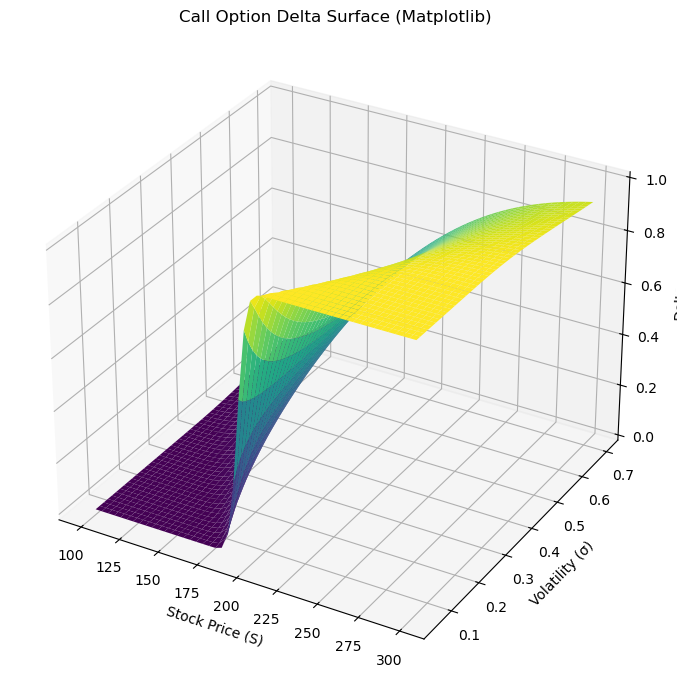

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#  Value ranges for S and sigma
S_vals = np.linspace(100, 300, 50)
sigma_vals = np.linspace(0.05, 0.7, 50)
S_grid, sigma_grid = np.meshgrid(S_vals, sigma_vals)

# Delta surface - Matplotlib
delta_grid = np.vectorize(lambda S, sigma: delta(S, K, T, r, sigma, option_type='call'))(S_grid, sigma_grid)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, sigma_grid, delta_grid, cmap='viridis')
ax.set_title("Call Option Delta Surface (Matplotlib)")
ax.set_xlabel("Stock Price (S)")
ax.set_ylabel("Volatility (σ)")
ax.set_zlabel("Delta")
plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go

# Delta surface - Plotly
delta_grid = np.vectorize(lambda S, sigma: delta(S, K, T, r, sigma, option_type='call'))(S_grid, sigma_grid)

fig = go.Figure(data=[go.Surface(
    z=delta_grid,
    x=S_grid,
    y=sigma_grid,
    colorscale='Viridis'
)])

fig.update_layout(
    title="Call Option Delta Surface (Plotly)",
    scene=dict(
        xaxis_title="Stock Price (S)",
        yaxis_title="Volatility (σ)",
        zaxis_title="Delta"
    )
)
fig.show()

## Gamma

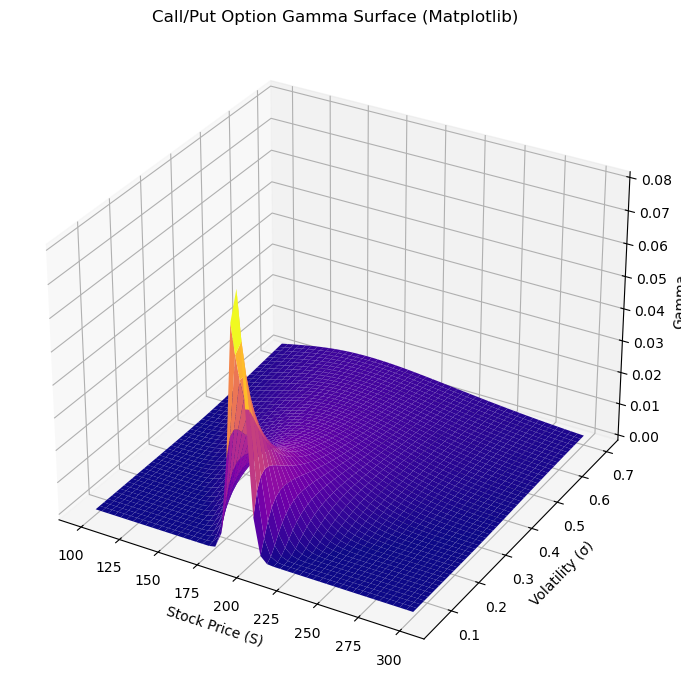

In [ ]:
# Gamma surface - Matplotlib
gamma_grid = np.vectorize(lambda S, sigma: gamma(S, K, T, r, sigma))(S_grid, sigma_grid)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, sigma_grid, gamma_grid, cmap='plasma')
ax.set_title("Call/Put Option Gamma Surface (Matplotlib)")
ax.set_xlabel("Stock Price (S)")
ax.set_ylabel("Volatility (σ)")
ax.set_zlabel("Gamma")
plt.tight_layout()
plt.show()

In [ ]:
# Gamma surface - Plotly
gamma_grid = np.vectorize(lambda S, sigma: gamma(S, K, T, r, sigma))(S_grid, sigma_grid)

fig = go.Figure(data=[go.Surface(
    z=gamma_grid,
    x=S_grid,
    y=sigma_grid,
    colorscale='Plasma'
)])

fig.update_layout(
    title="Call/Put Option Gamma Surface (Plotly)",
    scene=dict(
        xaxis_title="Stock Price (S)",
        yaxis_title="Volatility (σ)",
        zaxis_title="Gamma"
    )
)
fig.show()

## Vega

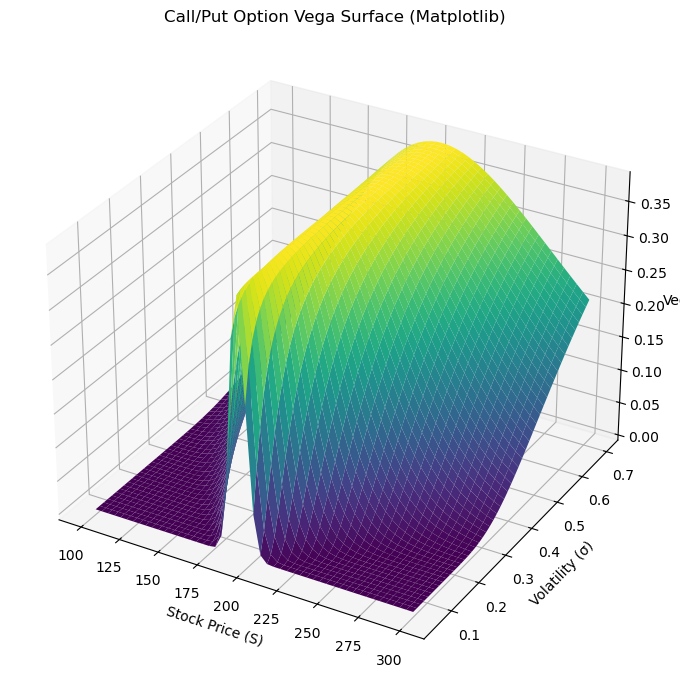

In [ ]:
# Vega surface - Matplotlib
vega_grid = np.vectorize(lambda S, sigma: vega(S, K, T, r, sigma))(S_grid, sigma_grid)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, sigma_grid, vega_grid, cmap='viridis')
ax.set_title("Call/Put Option Vega Surface (Matplotlib)")
ax.set_xlabel("Stock Price (S)")
ax.set_ylabel("Volatility (σ)")
ax.set_zlabel("Vega")
plt.tight_layout()
plt.show()

In [ ]:
# Vega surface - Plotly
fig = go.Figure(data=[go.Surface(
    z=vega_grid,
    x=S_grid,
    y=sigma_grid,
    colorscale='Viridis'
)])

fig.update_layout(
    title="Call/Put Option Vega Surface (Plotly)",
    scene=dict(
        xaxis_title="Stock Price (S)",
        yaxis_title="Volatility (σ)",
        zaxis_title="Vega"
    )
)
fig.show()

## Theta

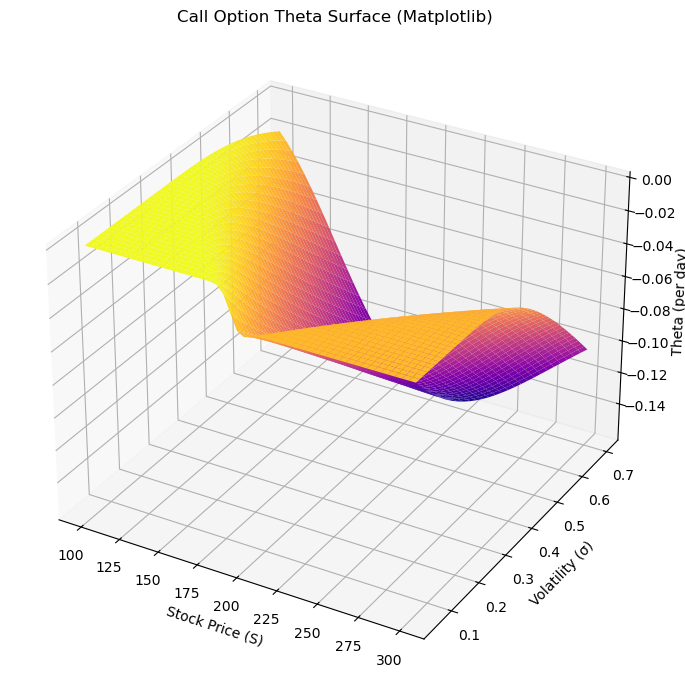

In [ ]:
# Theta surface - Matplotlib
theta_grid = np.vectorize(lambda S, sigma: theta(S, K, T, r, sigma, option_type='call'))(S_grid, sigma_grid)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, sigma_grid, theta_grid, cmap='plasma')
ax.set_title("Call Option Theta Surface (Matplotlib)")
ax.set_xlabel("Stock Price (S)")
ax.set_ylabel("Volatility (σ)")
ax.set_zlabel("Theta (per day)")
plt.tight_layout()
plt.show()

In [ ]:
# Theta surface - Plotly
fig = go.Figure(data=[go.Surface(
    z=theta_grid,
    x=S_grid,
    y=sigma_grid,
    colorscale='Plasma'
)])

fig.update_layout(
    title="Call Option Theta Surface (Plotly)",
    scene=dict(
        xaxis_title="Stock Price (S)",
        yaxis_title="Volatility (σ)",
        zaxis_title="Theta (per day)"
    )
)
fig.show()

## Rho

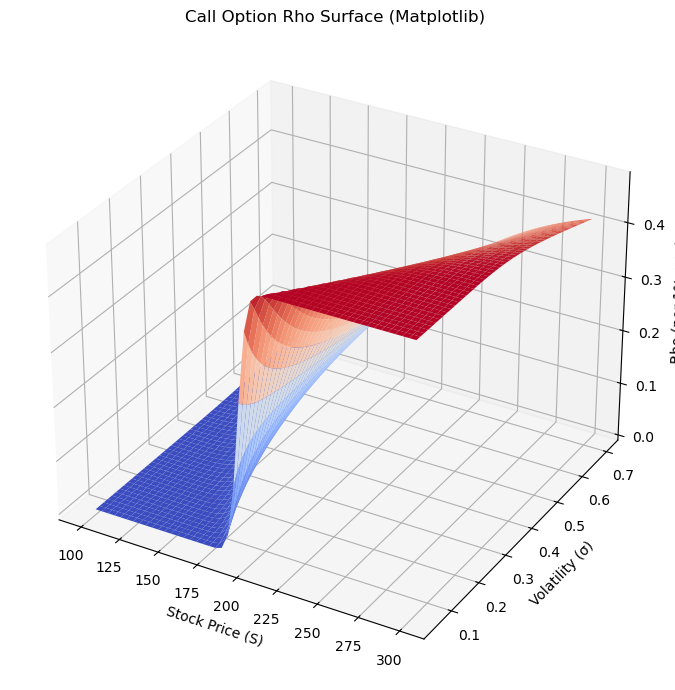

In [23]:
# Rho surface - Matplotlib
rho_grid = np.vectorize(lambda S, sigma: rho(S, K, T, r, sigma, option_type='call'))(S_grid, sigma_grid)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, sigma_grid, rho_grid, cmap='coolwarm')
ax.set_title("Call Option Rho Surface (Matplotlib)")
ax.set_xlabel("Stock Price (S)")
ax.set_ylabel("Volatility (σ)")
ax.set_zlabel("Rho (per 1% rate)")
plt.tight_layout()
plt.show()

In [ ]:
# Rho surface - Plotly
fig = go.Figure(data=[go.Surface(
    z=rho_grid,
    x=S_grid,
    y=sigma_grid,
    colorscale='RdBu'
)])

fig.update_layout(
    title="Call Option Rho Surface (Plotly)",
    scene=dict(
        xaxis_title="Stock Price (S)",
        yaxis_title="Volatility (σ)",
        zaxis_title="Rho (per 1% rate)"
    )
)
fig.show()